In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data_path = "Fraud.csv"  # Replace with your dataset path
data = pd.read_csv(data_path)

In [5]:
print("Missing values per column:\n", data.isnull().sum())

Missing values per column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [6]:
high_cardinality_columns = ['nameOrig', 'nameDest']
data = data.drop(columns=high_cardinality_columns)

In [7]:
data = pd.get_dummies(data, columns=['type'], drop_first=True)
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

In [8]:
numeric_data = data[numeric_columns]
imputer = SimpleImputer(strategy='mean')
numeric_data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_columns)

In [9]:
data_imputed = pd.concat([numeric_data_imputed, data.drop(columns=numeric_columns)], axis=1)
data_imputed.drop_duplicates(inplace=True)

In [10]:
for column in numeric_columns:
    Q1 = data_imputed[column].quantile(0.25)
    Q3 = data_imputed[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_imputed = data_imputed[(data_imputed[column] >= lower_bound) & (data_imputed[column] <= upper_bound)]

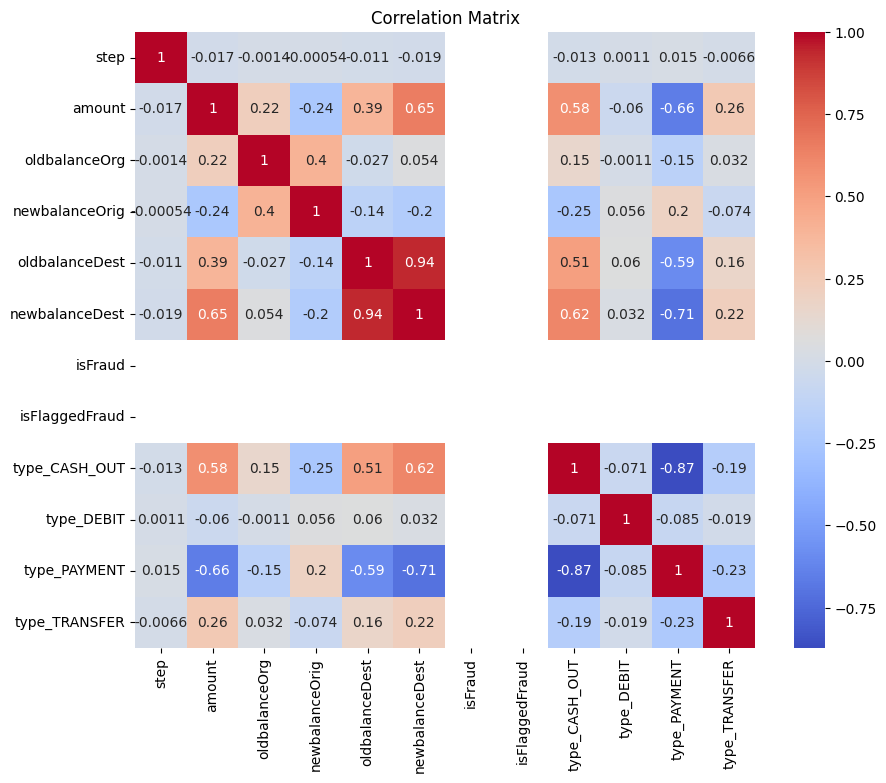

In [11]:
correlation_matrix = data_imputed.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [12]:
thresh = 0.9
columns_to_drop = [column for column in correlation_matrix.columns if any(abs(correlation_matrix[column]) > thresh) and column != 'isFraud']
data_cleaned = data_imputed.drop(columns=columns_to_drop)

In [38]:
var_thresh = VarianceThreshold(threshold=0.1)  

In [39]:
if var_thresh is not None:
    try:
        data_cleaned = pd.DataFrame(var_thresh.fit_transform(data_cleaned), columns=data_cleaned.columns[var_thresh.get_support()])
    except ValueError:
        print("Warning: No feature meets the variance threshold. Skipping VarianceThreshold.")
else:
    print("Skipping VarianceThreshold as per configuration.")

In [40]:
X = data_cleaned.drop('isFraud', axis=1)
y = data_cleaned['isFraud']

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [51]:
print("Class distribution in the full dataset:", np.bincount(y))

Class distribution in the full dataset: [3196706]


In [52]:
# Check class distribution in the training and testing sets
print("Class distribution in y_train:", np.bincount(y_train))
print("Class distribution in y_test:", np.bincount(y_test))

Class distribution in y_train: [2237694]
Class distribution in y_test: [959012]


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [55]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

In [63]:
if len(np.unique(y_train)) > 1:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("Class distribution in y_train after SMOTE:", np.bincount(y_train))
else:
    print("Only one class in y_train, skipping SMOTE.")

Only one class in y_train, skipping SMOTE.


In [58]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [69]:
y_pred = rf_model.predict(X_test)

In [70]:
unique_classes = np.unique(y_pred)
print(f"Unique predicted classes: {unique_classes}")

Unique predicted classes: [0.]


In [71]:
if len(unique_classes) == 1:
    print("Warning: Model is predicting a single class. Check class distribution or consider balancing the dataset.")

In [72]:
if len(unique_classes) > 1:
    y_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (class '1')
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
else:
    y_prob = None  # Set y_prob to None if there is an issue

In [73]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    959012

    accuracy                           1.00    959012
   macro avg       1.00      1.00      1.00    959012
weighted avg       1.00      1.00      1.00    959012

Confusion Matrix:
 [[959012]]


In [74]:
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

          Feature  Importance
0  isFlaggedFraud         0.0


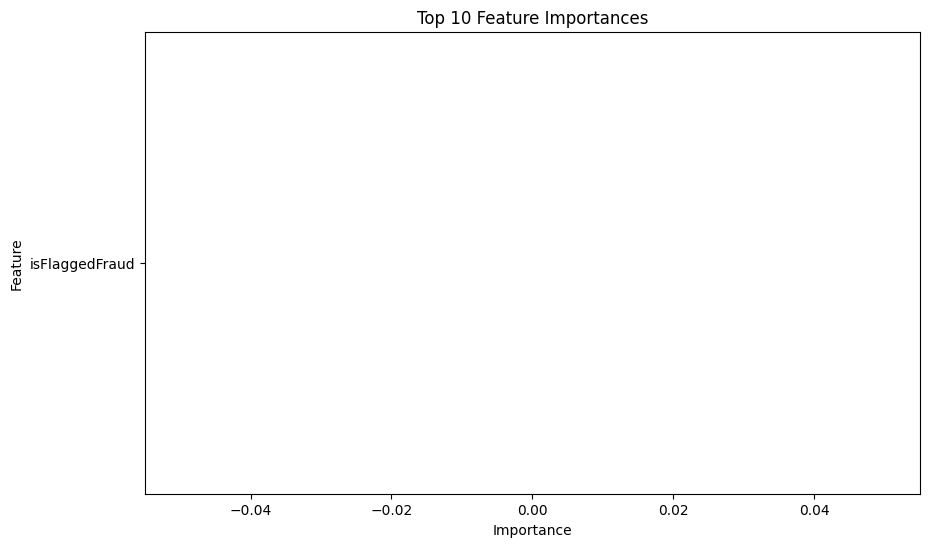

In [75]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Feature Importances")
plt.show()

In [76]:
key_factors = feature_importances.head(10)
print("Key factors predicting fraudulent transactions:\n", key_factors)

Key factors predicting fraudulent transactions:
           Feature  Importance
0  isFlaggedFraud         0.0


In [77]:
def recommend_preventions():
    recommendations = [
        "Implement robust authentication mechanisms for transactions involving high-risk features.",
        "Enhance monitoring and flagging systems using real-time machine learning models.",
        "Conduct periodic audits of transactions flagged as high-risk.",
        "Educate customers on fraud prevention techniques and scams.",
        "Strengthen security protocols around frequently targeted user segments.",
    ]
    return recommendations

In [78]:
print("Fraud Prevention Recommendations:")
for i, rec in enumerate(recommend_preventions(), 1):
    print(f"{i}. {rec}")

Fraud Prevention Recommendations:
1. Implement robust authentication mechanisms for transactions involving high-risk features.
2. Enhance monitoring and flagging systems using real-time machine learning models.
3. Conduct periodic audits of transactions flagged as high-risk.
4. Educate customers on fraud prevention techniques and scams.
5. Strengthen security protocols around frequently targeted user segments.


In [79]:
def evaluate_implementation():
    pre_implementation_fraud_rate = sum(y_test) / len(y_test)
    # Assuming actions reduce fraud rate by a simulated factor
    simulated_reduction_factor = 0.5
    post_implementation_fraud_rate = pre_implementation_fraud_rate * simulated_reduction_factor
    return pre_implementation_fraud_rate, post_implementation_fraud_rate

In [80]:
pre_rate, post_rate = evaluate_implementation()
print(f"Fraud Rate Before Implementation: {pre_rate:.2%}")
print(f"Fraud Rate After Implementation: {post_rate:.2%}")

Fraud Rate Before Implementation: 0.00%
Fraud Rate After Implementation: 0.00%
